<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [308]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import patsy
import re

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import statsmodels.api as sm

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [309]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [310]:
# A: Going to separate out the data into several smaller DataFrames to help me examine the data.
target = house['SalePrice']
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [311]:
#Straight away I can see a few columns that can be dropped. Street, Alley, LandContour, etc.
house.drop(columns=["Street","Alley","LandContour","Condition1","Condition2","1stFlrSF","2ndFlrSF","FireplaceQu"],inplace=True)

In [312]:
# My function to build Sub-Frames of the whole Data. 
# 'string' is for the phrase you want to search for in the columns by using Regex, can be used for different datasets.
def DF_Maker(string, data= house):
    # Labels that are being pulled by Regex, based on the string provided.
    labels = data.columns[data.columns.str.contains(string)]
    # Creates a Dataframe out of the column data labelled in the list provided in 'labels'
    df= data[labels]
    return(df)

In [313]:
bsmt_df = DF_Maker('Bsmt')
bsmt_df

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,706,Unf,0,150,856,1,0
1,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,0,1
2,Gd,TA,Mn,GLQ,486,Unf,0,434,920,1,0
3,TA,Gd,No,ALQ,216,Unf,0,540,756,1,0
4,Gd,TA,Av,GLQ,655,Unf,0,490,1145,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1455,Gd,TA,No,Unf,0,Unf,0,953,953,0,0
1456,Gd,TA,No,ALQ,790,Rec,163,589,1542,1,0
1457,TA,Gd,No,GLQ,275,Unf,0,877,1152,0,0
1458,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,1,0


In [314]:
# For analysis purposes I want to separate out like columns, E.G. Basement columns.
pool_df = DF_Maker('Pool')


In [315]:
lot_df= DF_Maker('Lot')
lot_df

,LotFrontage,LotArea,LotShape,LotConfig
0,65.0,8450,Reg,Inside
1,80.0,9600,Reg,FR2
2,68.0,11250,IR1,Inside
3,60.0,9550,IR1,Corner
4,84.0,14260,IR1,FR2
...,...,...,...,...
1455,62.0,7917,Reg,Inside
1456,85.0,13175,Reg,Inside
1457,66.0,9042,Reg,Inside
1458,68.0,9717,Reg,Inside


Might choose to 'class' plot pricing by the sizes of the plots

In [316]:
bath_df = DF_Maker('Bath')
bath_df

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,1,0,2,1
1,0,1,2,0
2,1,0,2,1
3,1,0,1,0
4,1,0,2,1
...,...,...,...,...
1455,0,0,2,1
1456,1,0,2,0
1457,0,0,2,0
1458,1,0,1,0


In [317]:
bath_df['HalfBath']= bath_df['HalfBath']/2
bath_df['BsmtHalfBath']=bath_df['BsmtHalfBath']/2
AllBath = []
for x in range(len(bath_df['FullBath'])):
    AllBath.append(bath_df['BsmtFullBath'][x] + bath_df['BsmtHalfBath'][x] + bath_df['FullBath'][x] + bath_df['HalfBath'][x])
    
house['AllBath']=AllBath
    

<ipython-input-317-d28e0d42488b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bath_df['HalfBath']= bath_df['HalfBath']/2
<ipython-input-317-d28e0d42488b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bath_df['BsmtHalfBath']=bath_df['BsmtHalfBath']/2


In [318]:
garage_df = DF_Maker('Garage')
garage_df

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA
...,...,...,...,...,...,...,...
1455,Attchd,1999.0,RFn,2,460,TA,TA
1456,Attchd,1978.0,Unf,2,500,TA,TA
1457,Attchd,1941.0,RFn,1,252,TA,TA
1458,Attchd,1950.0,Unf,1,240,TA,TA


I don't think I am going to attempt to include Garage into my predictions. Except perhaps the number of carspaces for a garage?

In [319]:
year_df = DF_Maker('Year')
year_df

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000
...,...,...
1455,1999,2000
1456,1978,1988
1457,1941,2006
1458,1950,1996


In [320]:
YrsOld = []
for x in year_df['YearBuilt']:
    YrsOld.append(2020-int(x))
house['YrsOld'] = YrsOld    
house['YrsOld']

0        17
1        44
2        19
3       105
4        20
       ... 
1455     21
1456     42
1457     79
1458     70
1459     55
Name: YrsOld, Length: 1460, dtype: int64

In [321]:
Rankings_df = house[['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','GarageQual','GarageCond','PoolQC']]
Rankings_df

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageQual,GarageCond,PoolQC
0,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,TA,TA,NaN
1,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,TA,TA,NaN
2,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,TA,TA,NaN
3,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,TA,TA,NaN
4,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,TA,TA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,5,TA,TA,Gd,TA,No,Unf,Unf,Ex,Y,TA,TA,TA,NaN
1456,6,6,TA,TA,Gd,TA,No,ALQ,Rec,TA,Y,TA,TA,TA,NaN
1457,7,9,Ex,Gd,TA,Gd,No,GLQ,Unf,Ex,Y,Gd,TA,TA,NaN
1458,5,6,TA,TA,TA,TA,Mn,GLQ,Rec,Gd,Y,Gd,TA,TA,NaN


In [322]:
Rankings_df.ExterQual.value_counts()

#bcw['malignant'] = bcw['malignant'].map(lambda x:0 if x == "B" else 1)

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [323]:
List = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond','PoolQC']
Change = pd.DataFrame(house[['OverallQual','OverallCond']])
for column in Rankings_df:
    if column in List:
        columnname = column
        col = pd.get_dummies(Rankings_df[column])
        try:
            col.Ex = (col.Ex)*5
        except:
            pass
        try:
            col.Gd = (col.Gd)*4
        except:
            pass
        try:
            col.TA = (col.TA)*3
        except:
            pass
        try:
            col.Fa = (col.Fa)*2
        except:
            pass
            
        mapping = {'Ex':columnname,'Fa':columnname,'Gd':columnname,'TA':columnname, 'Po':columnname}
        Change[columnname]=col[col.columns[:]].groupby(mapping,axis=1).sum()

In [324]:
List = ['BsmtExposure']

for column in Rankings_df:
    if column in List:
        columnname = column
        col = pd.get_dummies(Rankings_df[column])
        try:
            col.Gd = (col.Gd)*4
        except:
            pass
        try:
            col.Av = (col.Av)*3
        except:
            pass
        try:
            col.Mn = (col.Mn)*2
        except:
            pass
        try:
            col.No = (col.No)*1
        except:
            pass
            
            
        mapping = {'Gd':columnname,'Av':columnname,'Mn':columnname,'No':columnname}
        Change[columnname]=col[col.columns[:]].groupby(mapping,axis=1).sum()

In [325]:
List = ['BsmtFinType1','BsmtFinType2']

for column in Rankings_df:
    if column in List:
        columnname = column
        col = pd.get_dummies(Rankings_df[column])
        try:
            col.GLQ = (col.GLQ)*6
        except:
            pass
        try:
            col.ALQ = (col.ALQ)*5
        except:
            pass
        try:
            col.BLQ = (col.BLQ)*4
        except:
            pass
        try:
            col.Rec = (col.Rec)*3
        except:
            pass
        try:
            col.LwQ = (col.LwQ)*2
        except:
            pass
            
            
        mapping = {'GLQ':columnname,'ALQ':columnname,'BLQ':columnname,'Rec':columnname,'LwQ':columnname,'Unf':columnname}
        Change[columnname]=col[col.columns[:]].groupby(mapping,axis=1).sum()

In [326]:
List = ['CentralAir']

for column in Rankings_df:
    if column in List:
        columnname = column
        col = pd.get_dummies(Rankings_df[column])
            
        mapping = {'Y':columnname}
        Change[columnname]=col[col.columns[:]].groupby(mapping,axis=1).sum()
Change


,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC,BsmtExposure,BsmtFinType1,BsmtFinType2,CentralAir
0,7,5,4,3,4,3,5,4,3,3,0,1,6,1,1
1,6,8,3,3,4,3,5,3,3,3,0,4,5,1,1
2,7,5,4,3,4,3,5,4,3,3,0,2,6,1,1
3,7,5,3,3,3,4,4,4,3,3,0,1,5,1,1
4,8,5,4,3,4,3,5,4,3,3,0,3,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,5,3,3,4,3,5,3,3,3,0,1,1,1,1
1456,6,6,3,3,4,3,3,3,3,3,0,1,5,3,1
1457,7,9,5,4,3,4,5,4,3,3,0,1,6,1,1
1458,5,6,3,3,3,3,4,4,3,3,0,2,6,3,1


# HAHAHAHAHAHAHAHAHA Having spent all my time doing this I have come to the conclusion that I only need to take the Overall Quality and Condition and the rest are superfluous and unneccessary in my calculations.

In [327]:
Change.describe().T

,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,6.0,7.0,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.0,5.0,6.0,9.0
ExterQual,1460.0,3.395890,0.574280,2.0,3.0,3.0,4.0,5.0
ExterCond,1460.0,3.083562,0.351054,1.0,3.0,3.0,3.0,5.0
BsmtQual,1460.0,3.489041,0.876478,0.0,3.0,4.0,4.0,5.0
BsmtCond,1460.0,2.934932,0.552159,0.0,3.0,3.0,3.0,4.0
HeatingQC,1460.0,4.145205,0.959501,1.0,3.0,5.0,5.0,5.0
KitchenQual,1460.0,3.511644,0.663760,2.0,3.0,3.0,4.0,5.0
GarageQual,1460.0,2.810274,0.722898,0.0,3.0,3.0,3.0,5.0
GarageCond,1460.0,2.808904,0.719685,0.0,3.0,3.0,3.0,5.0


In [328]:
print(house.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape Utilities LotConfig  \
0   1          60       RL         65.0     8450      Reg    AllPub    Inside   
1   2          20       RL         80.0     9600      Reg    AllPub       FR2   
2   3          60       RL         68.0    11250      IR1    AllPub    Inside   
3   4          70       RL         60.0     9550      IR1    AllPub    Corner   
4   5          60       RL         84.0    14260      IR1    AllPub       FR2   

  LandSlope Neighborhood  ... Fence MiscFeature  MiscVal  MoSold  YrSold  \
0       Gtl      CollgCr  ...   NaN         NaN        0       2    2008   
1       Gtl      Veenker  ...   NaN         NaN        0       5    2007   
2       Gtl      CollgCr  ...   NaN         NaN        0       9    2008   
3       Gtl      Crawfor  ...   NaN         NaN        0       2    2006   
4       Gtl      NoRidge  ...   NaN         NaN        0      12    2008   

   SaleType SaleCondition SalePrice AllBath YrsOld  
0  

In [329]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'F

# The Column Data worth working with:

In [330]:
df = house.copy(deep=True)

In [331]:
List = ['OverallQual','YrsOld','AllBath','LotArea']

In [332]:
X= house[List]
y= target

In [333]:
#from sklearn.linear_model import LogisticRegression

In [334]:
#lr = LogisticRegression()

In [335]:
#lr.fit(X,y)

In [336]:
X0 = house.LotArea
y0 = target

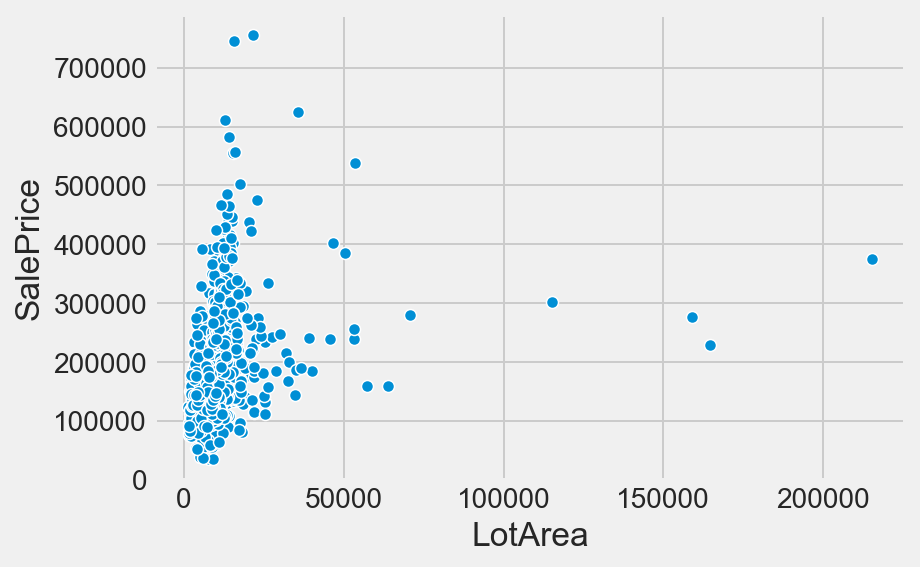

In [337]:
sns.scatterplot(X0,y0)

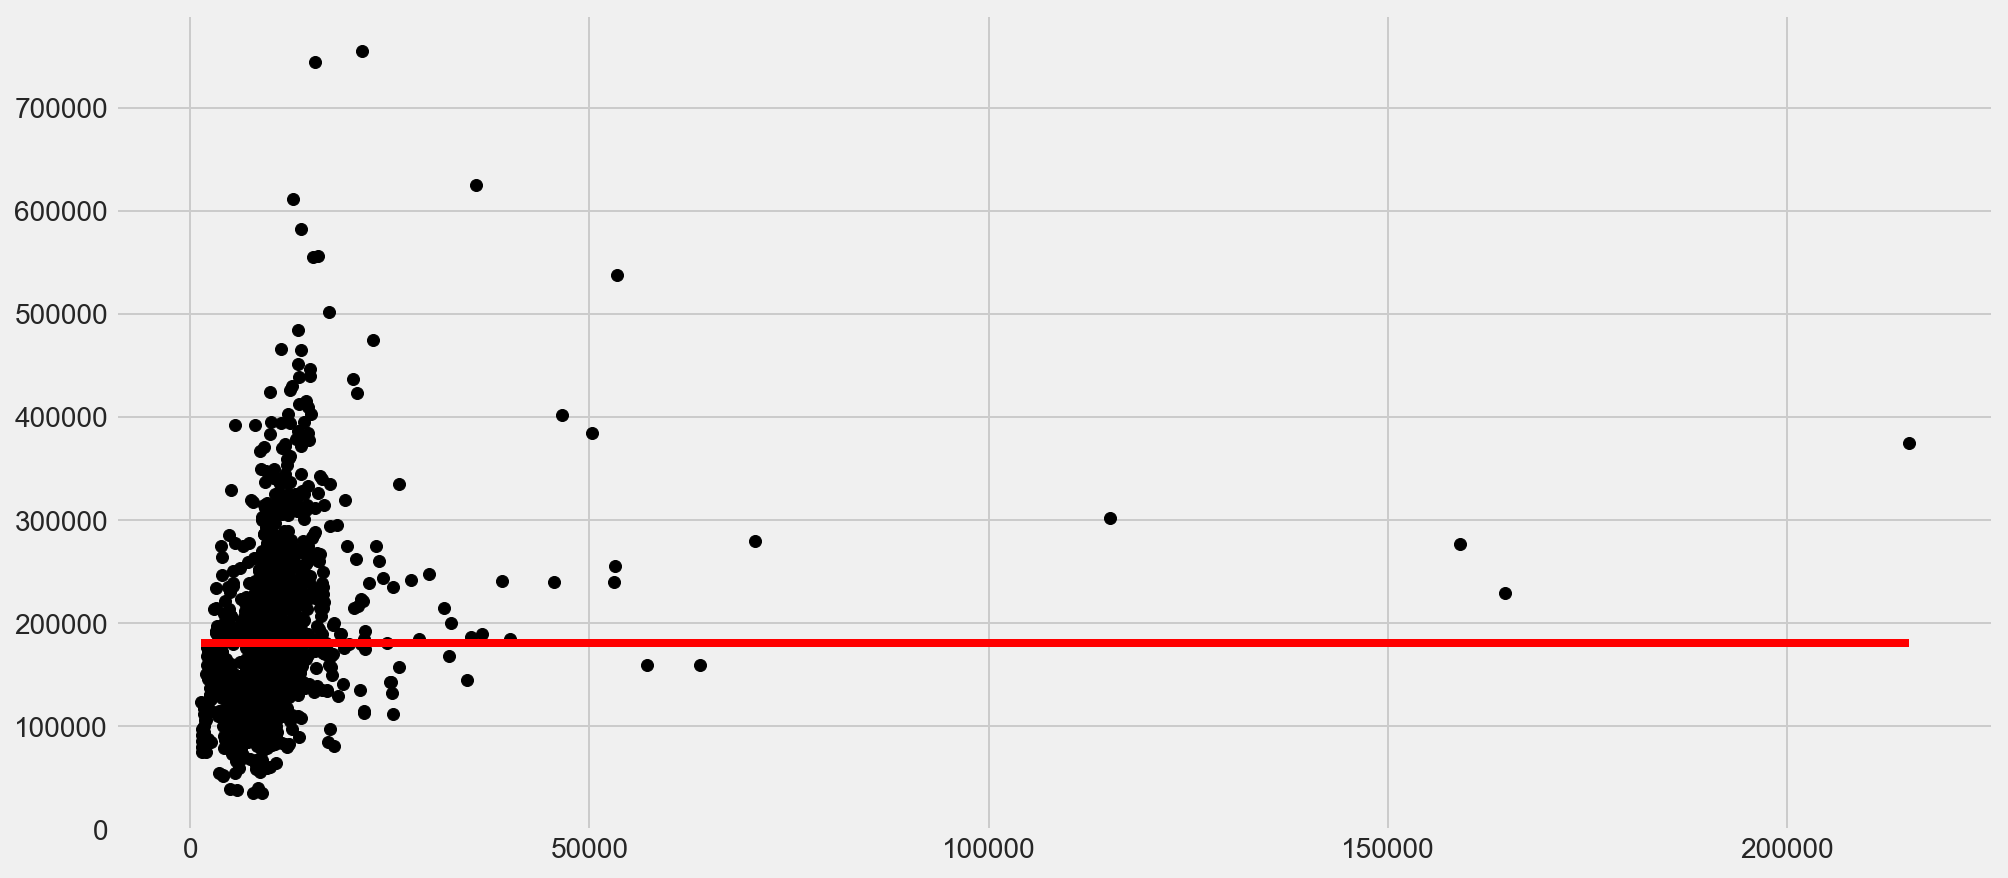

In [338]:
### Plot the data
# create a figure
fig = plt.figure(figsize=(15,7))
# get the axis of that figure
ax = plt.gca()

# plot a scatter plot on it with our data
ax.scatter(X0, y0, c='k')
ax.plot((house.LotArea.min(), house.LotArea.max()),(np.mean(target), np.mean(target)), color='r');

In [339]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error


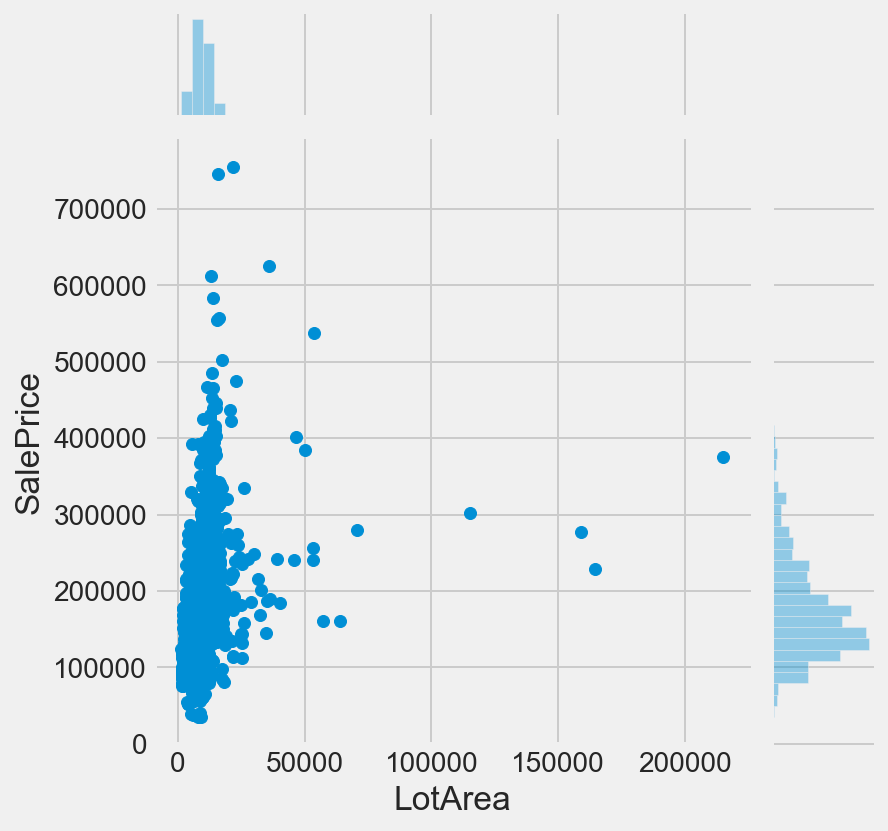

In [340]:
sns.jointplot(house['LotArea'], target)

# Linear Regression time!

In [341]:
# target
price = target
# predictor
sqft = house.LotArea.values

In [342]:
def calculate_yhat(x, b0, b1):
    return b0 + b1*x

In [343]:
def plot_regression(x, y, b0, b1):
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca()
    # Predictive Function
    yhat = calculate_yhat(x, b0, b1)
    # y-true
    ax.scatter(x, y, color='steelblue', s=70)
    # y-pred
    ax.scatter(x, yhat, color='darkred', s=70, alpha=0.3)
    
    min_x, max_x = np.min(x), np.max(x)
    min_yhat = calculate_yhat(min_x, b0, b1)
    max_yhat = calculate_yhat(max_x, b0, b1)
    
    # plots trend line
    ax.plot([min_x, max_x], [min_yhat, max_yhat], color='darkred',
            linewidth=2.0, alpha=0.7)
    
    plt.show()


In [344]:
def calculate_residuals(y, yhat):
    return y - yhat

In [345]:
def sum_sq_errors(errors):
    return np.sum(errors**2)

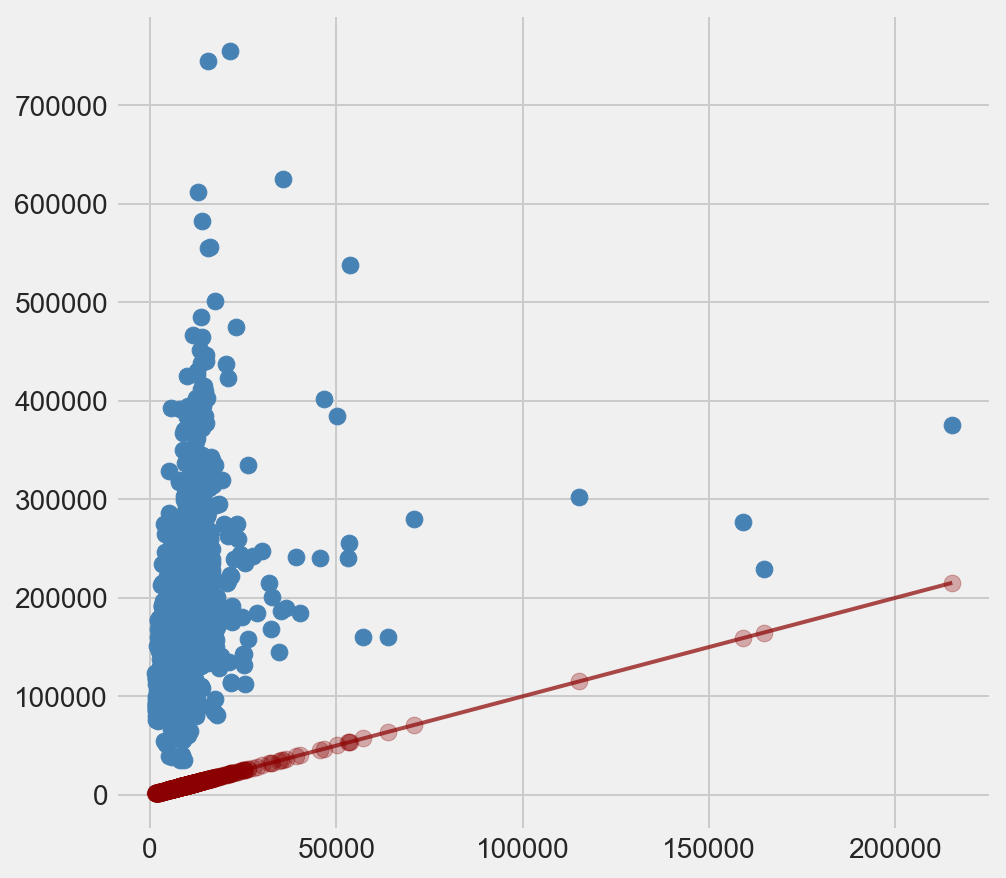

In [346]:
b0 = 0
b1 = 1
plot_regression(sqft, price, b0, b1)

In [347]:
price_hat = calculate_yhat(sqft, b0, b1)
residuals = calculate_residuals(price, price_hat)
sse = sum_sq_errors(residuals)
print(sse)

51137754164829


In [348]:
List

['OverallQual', 'YrsOld', 'AllBath', 'LotArea']

In [349]:
print('gradient: '+str((target.max()-target.min())/(sqft.max()-sqft.min())))

gradient: 3.365818317791956


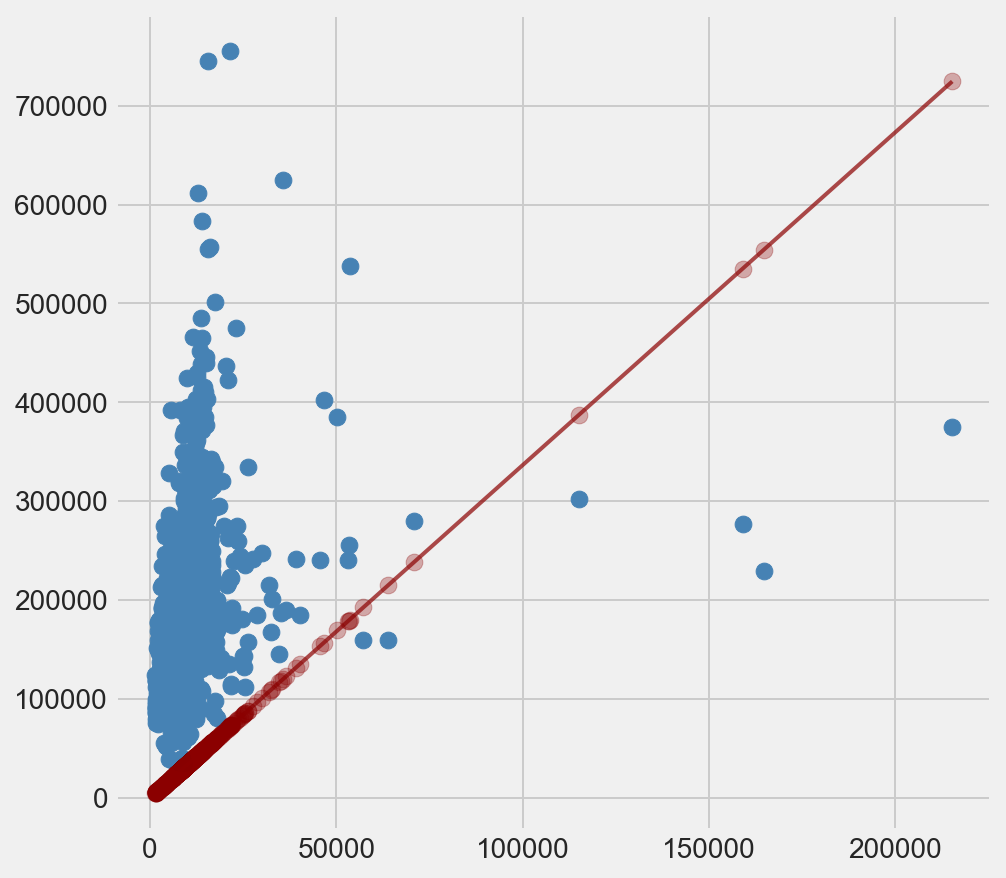

39718362686765.836


In [350]:
b0 = 0
b1 = 3.365818317791956
plot_regression(sqft, price, b0, b1)

price_hat = calculate_yhat(sqft, b0, b1)
residuals = calculate_residuals(price, price_hat)
sse = sum_sq_errors(residuals)
print(sse)

In [351]:
def calc_beta_one(x, y):
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    numerator = np.sum((y - mean_y)*(x - mean_x))
    denominator = np.sum((x - mean_x)**2)
    
    return numerator/denominator

    
def calc_beta_zero(x, y, b1):
    
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    return mean_y - b1*mean_x

In [352]:
b1 = calc_beta_one(sqft, price)
b0 = calc_beta_zero(sqft, price, b1)
print(b1, b0)

2.0999719517076745 158836.1518968766


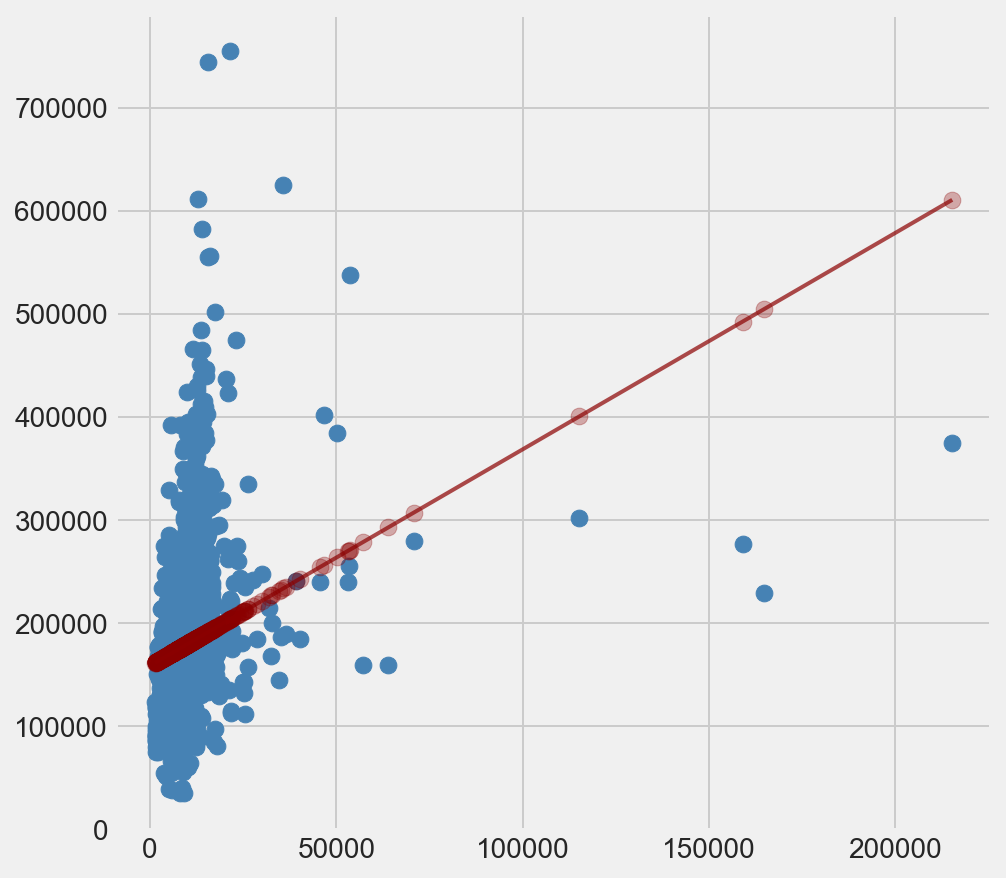

8566918098863.25


In [353]:
plot_regression(sqft, price, b0, b1)

price_hat = calculate_yhat(sqft, b0, b1)
residuals = calculate_residuals(price, price_hat)
sse = sum_sq_errors(residuals)
print(sse)

In [354]:
#51137754164829.000
#39718362686765.836
# 8566918098863.250

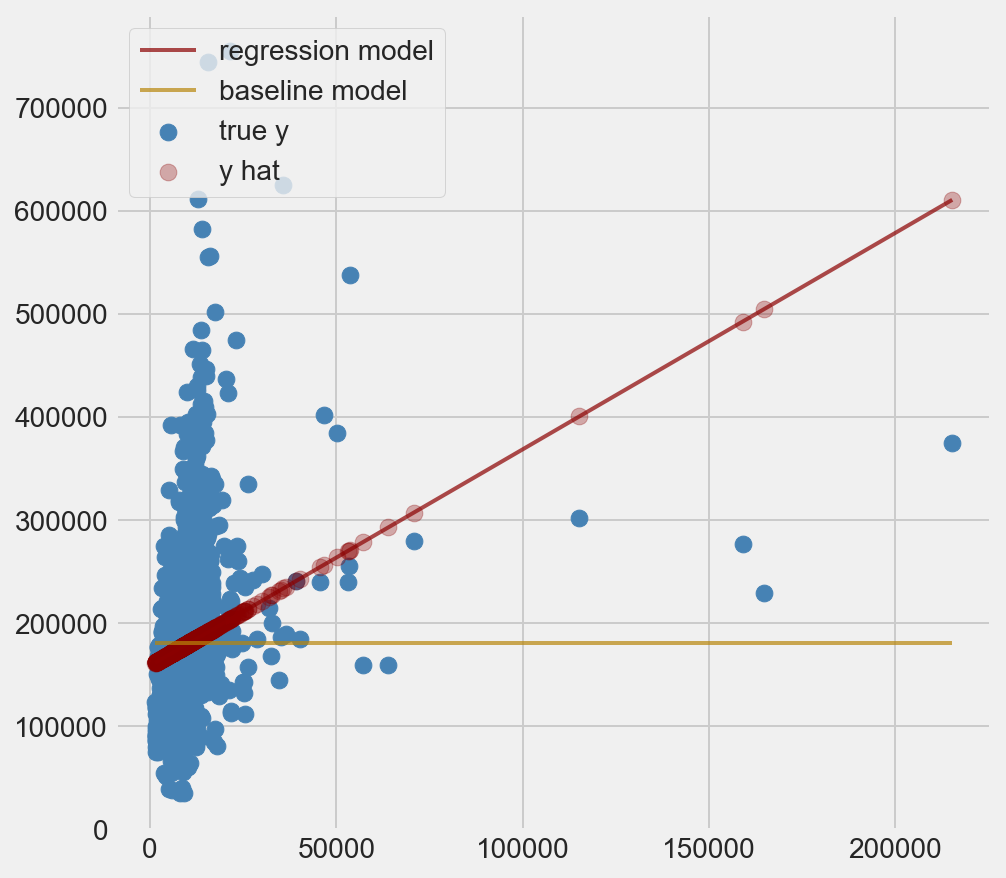

In [355]:
def estimate_betas(x, y):
    b1 = calc_beta_one(x, y)
    b0 = calc_beta_zero(x, y, b1)
    return b0, b1

def plot_regression_wbaseline(x, y, b0, b1):
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca()
    # predictive function
    yhat = calculate_yhat(x, b0, b1)
    ymean = np.mean(y)
    # y-true
    ax.scatter(x, y, color='steelblue', s=70, label='true y')
    # y-pred
    ax.scatter(x, yhat, color='darkred', s=70, alpha=0.3, label='y hat')
    
    min_x, max_x = np.min(x), np.max(x)
    min_yhat = calculate_yhat(min_x, b0, b1)
    max_yhat = calculate_yhat(max_x, b0, b1)
    # y-pred trend line
    ax.plot([min_x, max_x], [min_yhat, max_yhat], color='darkred',
            linewidth=2.0, alpha=0.7, label='regression model')
    # y-intercept
    ax.plot([min_x, max_x], [ymean, ymean], color='darkgoldenrod',
            linewidth=2.0, alpha=0.7, label='baseline model')
    
    plt.legend(loc='upper left')
    
    plt.show()

b0, b1 = estimate_betas(sqft, price)
plot_regression_wbaseline(sqft, price, b0, b1)

In [356]:
def calculate_r2(y, yhat):
    # estimated error 
    err_tot = (y-np.mean(y))**2
    # residual error
    err_res = (y - yhat)**2
    # total sum of squares
    ss_tot = np.sum(err_tot)
    # residual sum of squares
    ss_res = np.sum(err_res)
    return 1 - (ss_res/ss_tot)

yhat = calculate_yhat(sqft, b0, b1)
print('Regression R^2:', calculate_r2(price, yhat))
print('Baseline R^2:', calculate_r2(price, np.mean(price)))

Regression R^2: 0.0696133153821118
Baseline R^2: 0.0


Transforming from simple to Multi-Linear.

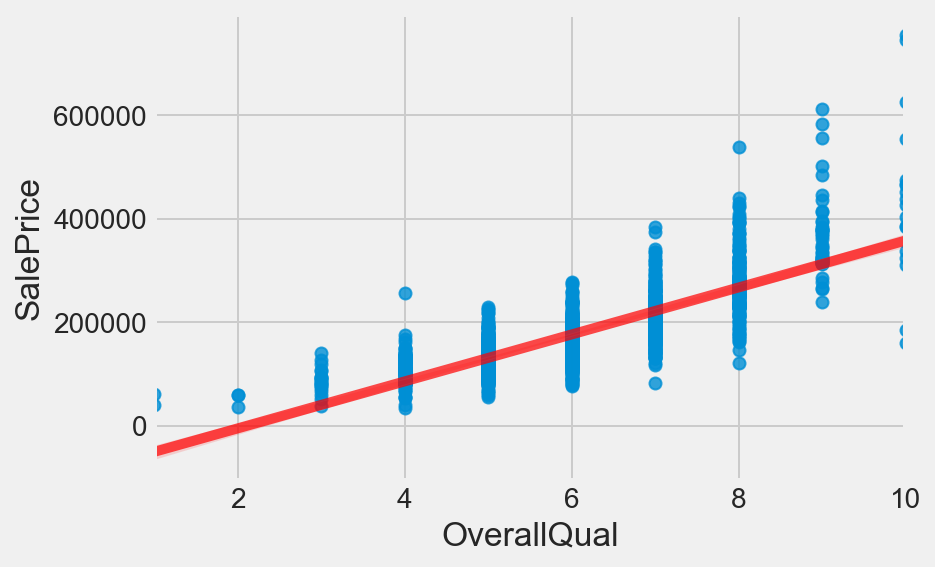

In [357]:
# plot
sns.regplot(x=X['OverallQual'], y=target, line_kws={"color":"r","alpha":0.7,"lw":5})

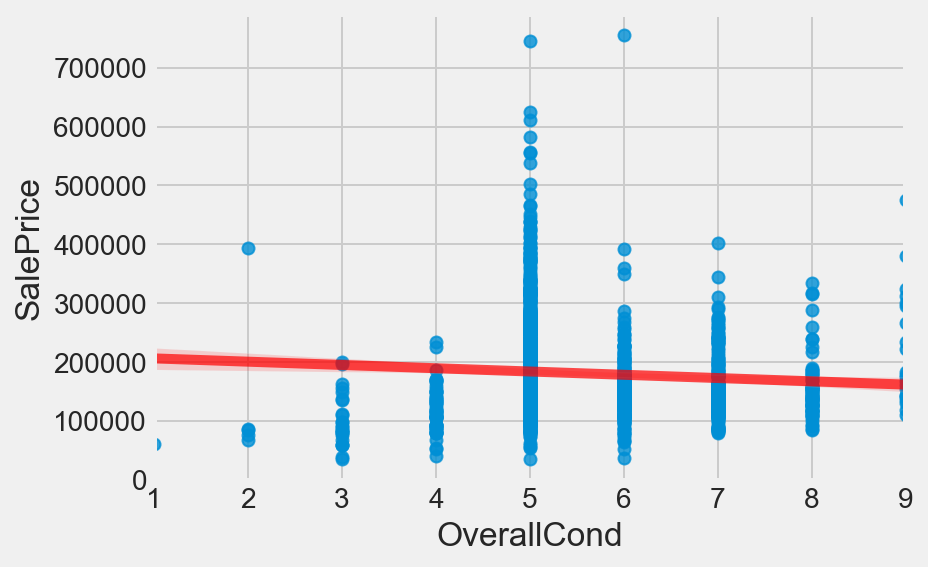

In [358]:
sns.regplot(x=house['OverallCond'], y=target, line_kws={"color":"r","alpha":0.7,"lw":5})

## OverallCond is not a good predictor, and can actually be changed by the company. So this will be removed from my core choices.

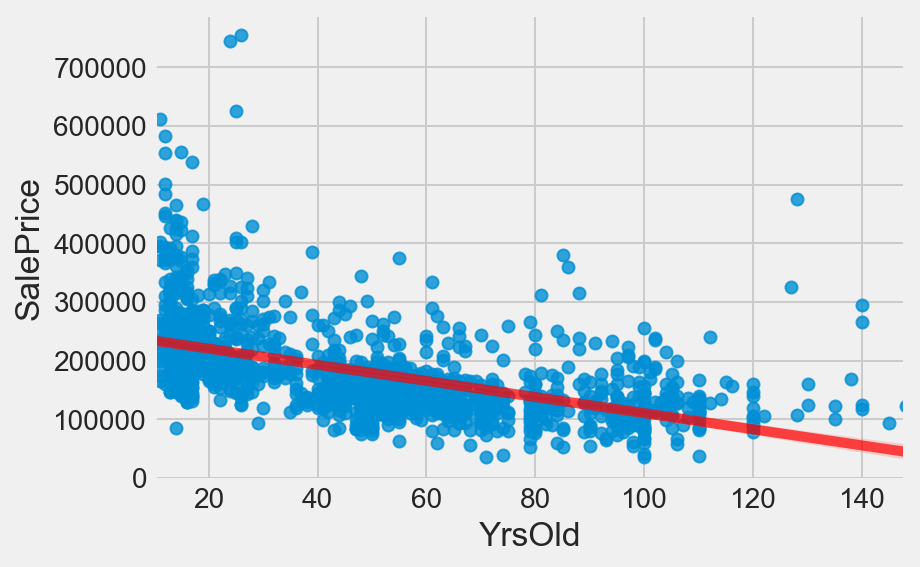

In [359]:
sns.regplot(x=X['YrsOld'], y=target, line_kws={"color":"r","alpha":0.7,"lw":5})

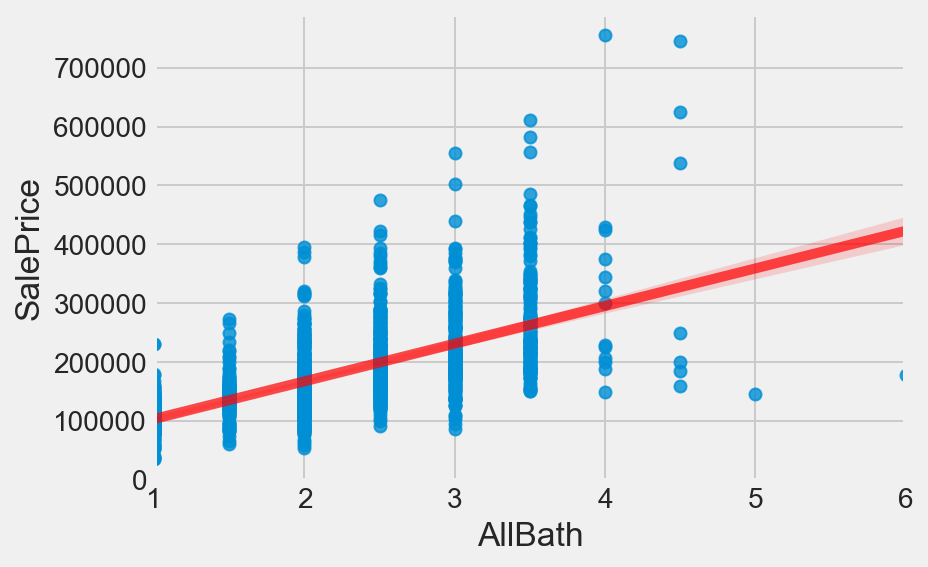

In [360]:
sns.regplot(x=X['AllBath'], y=target, line_kws={"color":"r","alpha":0.7,"lw":5})

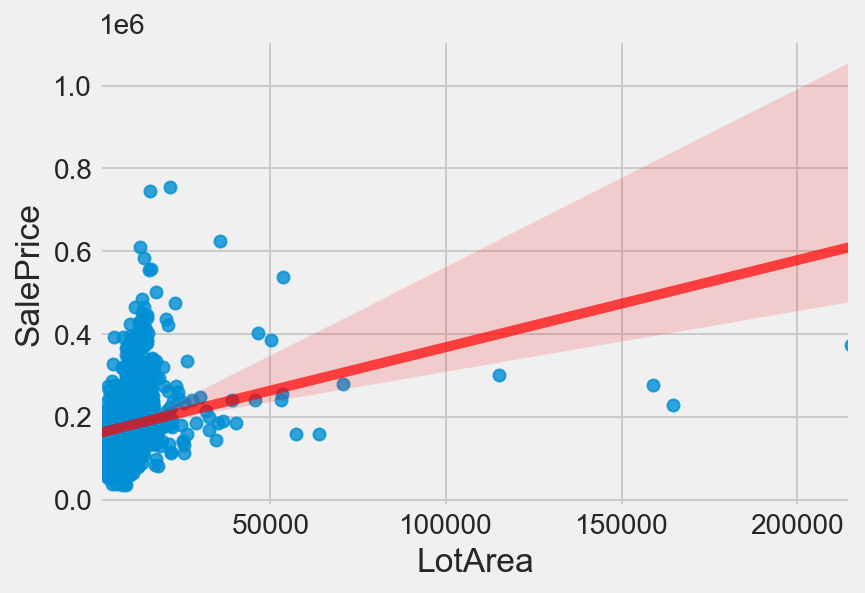

In [361]:
sns.regplot(x=X['LotArea'], y=target, line_kws={"color":"r","alpha":0.7,"lw":5})

If I had more time I could have done some calculation with neighborhood. I could have calculated mean price for each space, then bracketed them into low, medium, high pricing. Or some such.

In [363]:
X = house[['OverallQual', 'YrsOld', 'AllBath', 'LotArea']]

In [364]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [292]:
X.describe()

,OverallQual,YrsOld,AllBath,LotArea
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,48.732192,2.210616,10516.828082
std,1.382997,30.202904,0.785399,9981.264932
min,1.000000,10.000000,1.000000,1300.000000
25%,5.000000,20.000000,2.000000,7553.500000
50%,6.000000,47.000000,2.000000,9478.500000
75%,7.000000,66.000000,2.500000,11601.500000
max,10.000000,148.000000,6.000000,215245.000000


In [375]:
X= house[List]
y = target 
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [376]:
lm = linear_model.LinearRegression()
#from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(
    Xs, y, test_size=0.5, random_state=20)

In [377]:
linreg = LinearRegression(fit_intercept=False)
linreg.fit(Xs, price)

print('Intercept: ',linreg.intercept_)
print('Coefficients: ',linreg.coef_)

Intercept:  0.0
Coefficients:  [49357.55978083 -2845.83673559 19579.61175249 11681.19652286]


In [371]:
List

['OverallQual', 'YrsOld', 'AllBath', 'LotArea']

In [380]:

model = sm.OLS(y,X).fit()

y_pred = model.predict(X)

In [382]:

df['y_pred'] = y_pred
df['Residuals'] = df['SalePrice'] - df['y_pred']

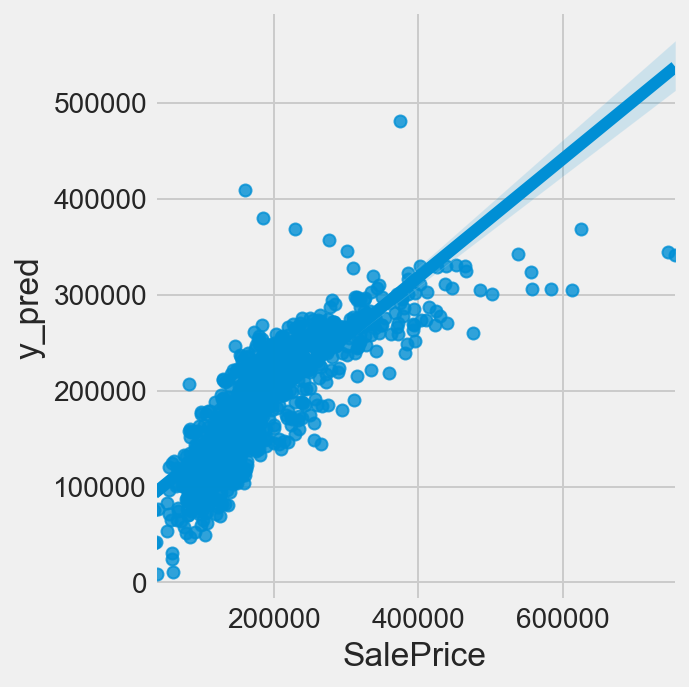

In [383]:
sns.lmplot(x='SalePrice', y='y_pred', data=df,)

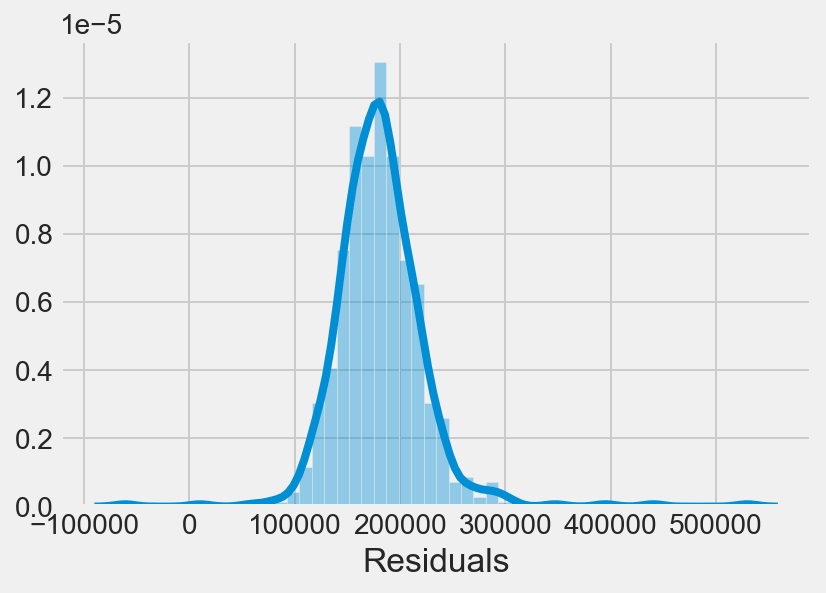

In [99]:
sns.distplot(df['Residuals'])

In [384]:
df['Residuals']

0      -35896.432722
1       -5543.810787
2      -23151.638985
3      -30069.688052
4      -25524.577913
            ...     
1455   -22742.049442
1456     8563.752151
1457    82662.643938
1458     4125.873356
1459    -8052.906109
Name: Residuals, Length: 1460, dtype: float64

In [ ]:
model.summary()

But has all this been overfitting? I did not create a test and train sample.

In [ ]:
print('Multiple regression R^2:', calculate_r2(price, yhat))

In [ ]:
List

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=20)

In [167]:

model = sm.OLS(y_train,X_train).fit()

y_pred = model.predict(X_test)

In [168]:
df['y_test'] = pd.DataFrame(y_test)
df['y_pred'] = y_pred
df['Residuals'] = df['y_test'] - df['y_pred']

In [169]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,Utilities,LotConfig,LandSlope,Neighborhood,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AllBath,YrsOld,y_test,y_pred,Residuals
0,1,60,RL,65.0,8450,Reg,AllPub,Inside,Gtl,CollgCr,...,2,2008,WD,Normal,208500,3.5,17,208500.0,248330.708925,-39830.708925
1,2,20,RL,80.0,9600,Reg,AllPub,FR2,Gtl,Veenker,...,5,2007,WD,Normal,181500,2.5,44,181500.0,188536.095757,-7036.095757
2,3,60,RL,68.0,11250,IR1,AllPub,Inside,Gtl,CollgCr,...,9,2008,WD,Normal,223500,3.5,19,NaN,NaN,NaN
3,4,70,RL,60.0,9550,IR1,AllPub,Corner,Gtl,Crawfor,...,2,2006,WD,Abnorml,140000,2.0,105,NaN,NaN,NaN
4,5,60,RL,84.0,14260,IR1,AllPub,FR2,Gtl,NoRidge,...,12,2008,WD,Normal,250000,3.5,20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Reg,AllPub,Inside,Gtl,Gilbert,...,8,2007,WD,Normal,175000,2.5,21,NaN,NaN,NaN
1456,1457,20,RL,85.0,13175,Reg,AllPub,Inside,Gtl,NWAmes,...,2,2010,WD,Normal,210000,3.0,42,NaN,NaN,NaN
1457,1458,70,RL,66.0,9042,Reg,AllPub,Inside,Gtl,Crawfor,...,5,2010,WD,Normal,266500,2.0,79,NaN,NaN,NaN
1458,1459,20,RL,68.0,9717,Reg,AllPub,Inside,Gtl,NAmes,...,4,2010,WD,Normal,142125,2.0,70,NaN,NaN,NaN


In [ ]:
linreg = LinearRegression(fit_intercept=False)
linreg.fit(X, price)

print('Intercept: ',linreg.intercept_)
print('Coefficients: ',linreg.coef_)

In [ ]:
#from sklearn.model_selection import train_test_split
#from sklearn import datasets
#from sklearn import svm

In [ ]:


#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [ ]:
#from sklearn.metrics import mean_squared_error
#ols1= LinearRegression()
#ols1.fit(X_train, y_train)
#ols1.predict()

In [ ]:
#predprice = ols1.predict(data_train)
#predprice[:5]

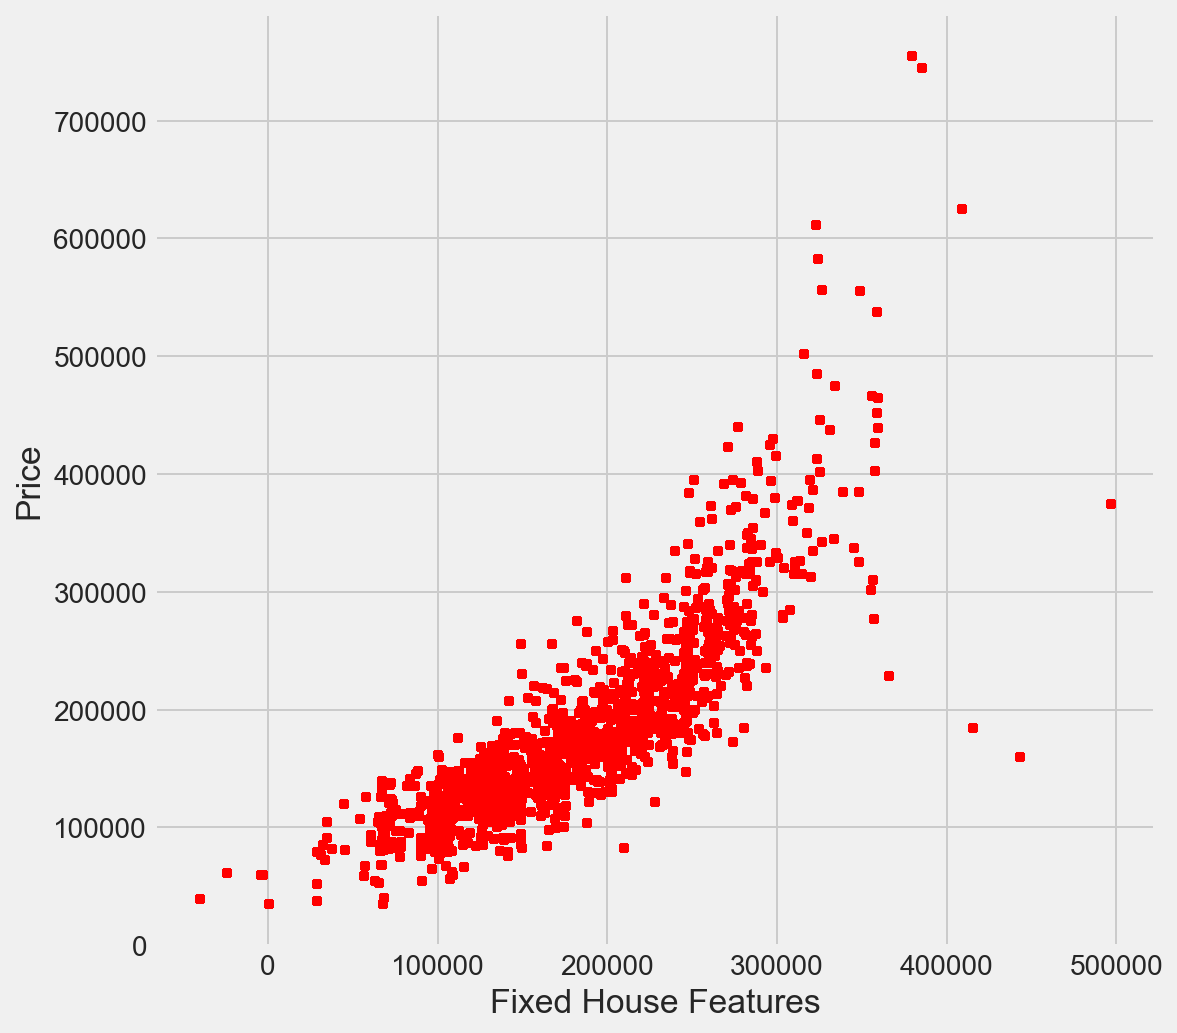

score:  0.7049027442401425


In [300]:
model = lm.fit(X, y)

predictions  =  model.predict(X)
score        =  model.score(X, y)

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Fixed House Features")
plt.ylabel("Price")
plt.show()

print("score: ", score)

In [ ]:
print(model.coef_)

In [ ]:
# For a 1-unit increase in OverallQual, there is a $35700 increase in price
# For a 1-unit increase in YrsOld, there is a $94.3 decrease in price
# For a 1-unit increase in AllBath, there is a $24900 increase in price
# For a 1-unit increase in LotArea, there is a $1.17 increase in price

In [ ]:
List

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [ ]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

In [ ]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

In [ ]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

In [ ]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

In [122]:
List

['OverallQual', 'YrsOld', 'AllBath', 'LotArea']

In [97]:
# Importing the stats model API
import statsmodels.api as sm

# Setting my X and y for modeling
X= house[List]
y = target 

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()

y_pred = model.predict(X)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)

In [121]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(438, 4) (438,)
(1022, 4) (1022,)


In [108]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression()

In [110]:
print(slr.score(X_train, y_train))

0.7126559447893789


In [111]:
print(slr.score(X_test, y_test))

0.6952081000867669


Cross-validated scores: [0.70737592 0.63789456 0.69240445 0.68968949 0.72807901]
Cross-Predicted R2: 0.6669401031760318


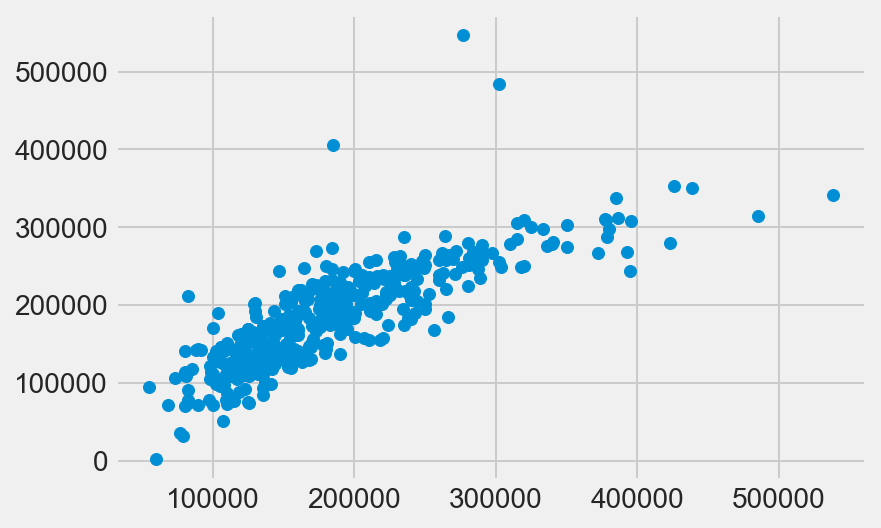

In [117]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
scores = cross_val_score(slr, X_train, y_train, cv=5)
print("Cross-validated scores:", scores)

# Make cross validated predictions on the test sets
predictions = cross_val_predict(slr, X_test, y_test, cv=5)
plt.scatter(y_test, predictions)
test_Residue = (y_test - predictions)

# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print("Cross-Predicted R2:", r2)

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=8)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train,y_train)

lr.score(X_test, y_test)

0.7058950911531996

In [ ]:
X_train, y_train
X_test, y_test
.fit(X_train,y_train)
.predict(x_test,y_test)

test_Residue = (y_test - y_test_predicted)

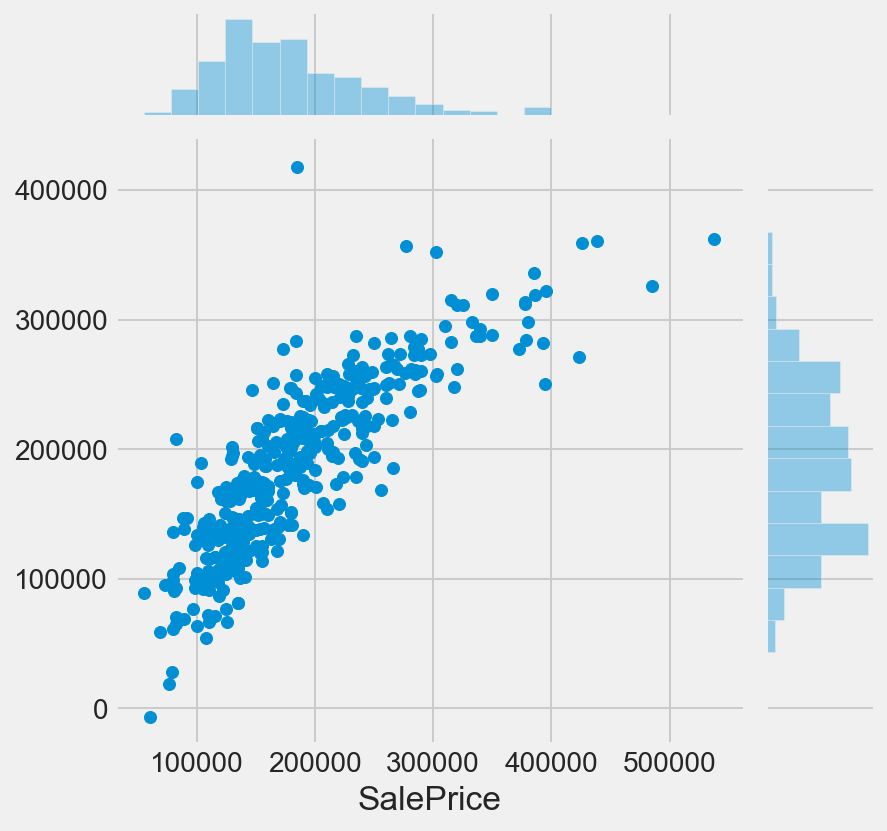

In [79]:
yhat = lr.predict(X_test)
sns.jointplot(y_test, yhat)

In [81]:

# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

In [82]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[0.75102343 0.72507271 0.69700671 0.67747303 0.68627568 0.68955499
 0.70345675 0.70774286 0.62115718 0.73284094]
0.6991604291198353


In [85]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

76.63410868007459


In [87]:
optimal_ridge

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=10)

In [86]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.76178346 0.71604908 0.71304817 0.6817507  0.67872232 0.68320751
 0.70851997 0.71441736 0.61359419 0.73618041]
0.7007273161353587


In [115]:
X_train, y_train
X_test, y_test
.fit(X_train,y_train)
.predict(x_test,y_test)

test_Residue = (y_test - y_test_predicted)

SyntaxError: invalid syntax (<ipython-input-115-4c4cca32c519>, line 3)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [4]:
# A: From model made for P1. Find the difference between predicted and actual. This difference for each becomes data set for the new model to be made with changeable variables.

In [118]:
test_Residue

1260    -21848.591030
274       7104.934505
51      -27628.703598
117      24180.610261
789       5281.970840
            ...      
622      22527.449108
1401     -2912.010142
1146    -14222.515508
664     142831.842361
969     -31307.923965
Name: SalePrice, Length: 439, dtype: float64

In [19]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'F

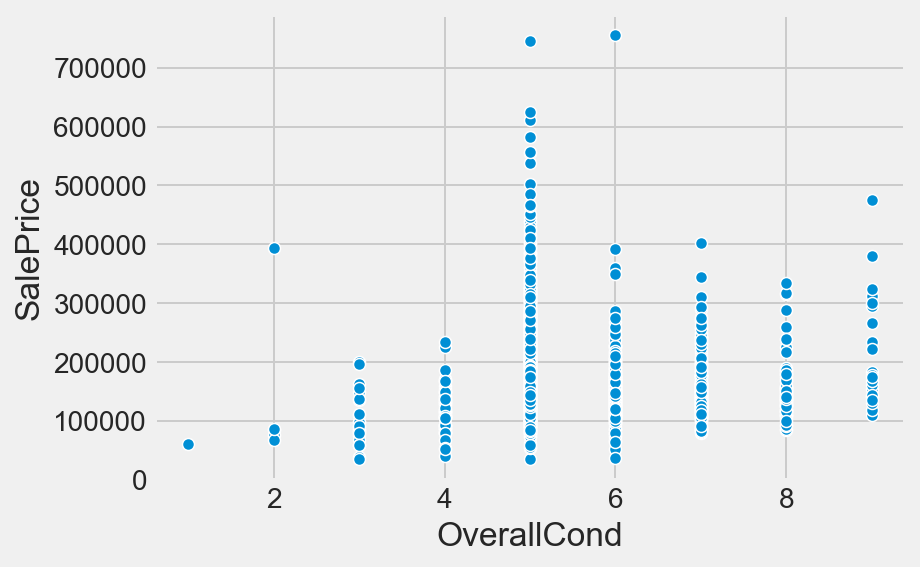

In [32]:
sns.scatterplot(df['OverallCond'], target)

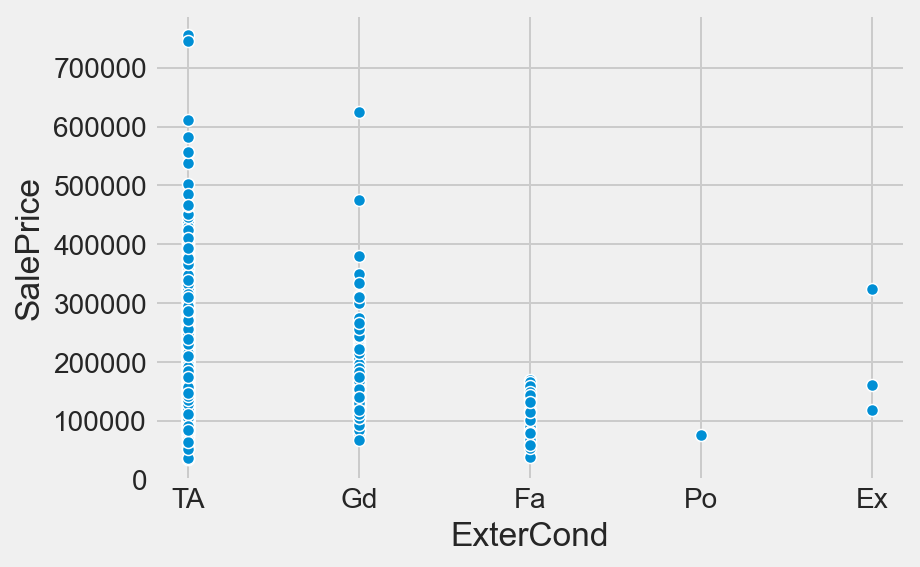

In [33]:
sns.scatterplot(df['ExterCond'], target)

In [ ]:
df.groupby('OverallCond')

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df['OverallCond'], test_Residue, test_size=0.5, random_state=0)

ValueError: Found input variables with inconsistent numbers of samples: [1460, 439]

In [307]:
# Perform 5-fold cross validation
scores = cross_val_score(, X_train, y_train, cv=5)
print("Cross-validated scores:", scores)

# Make cross validated predictions on the test sets
predictions = cross_val_predict(house, X_test, y_test, cv=5)
plt.scatter(y_test, predictions)
test_Residue = (y_test - predictions)

# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print("Cross-Predicted R2:", r2)

TypeError: estimator should be an estimator implementing 'fit' method,         Id  MSSubClass MSZoning  LotFrontage  LotArea LotShape Utilities  \
0        1          60       RL         65.0     8450      Reg    AllPub   
1        2          20       RL         80.0     9600      Reg    AllPub   
2        3          60       RL         68.0    11250      IR1    AllPub   
3        4          70       RL         60.0     9550      IR1    AllPub   
4        5          60       RL         84.0    14260      IR1    AllPub   
...    ...         ...      ...          ...      ...      ...       ...   
1455  1456          60       RL         62.0     7917      Reg    AllPub   
1456  1457          20       RL         85.0    13175      Reg    AllPub   
1457  1458          70       RL         66.0     9042      Reg    AllPub   
1458  1459          20       RL         68.0     9717      Reg    AllPub   
1459  1460          20       RL         75.0     9937      Reg    AllPub   

     LotConfig LandSlope Neighborhood  ...  Fence MiscFeature  MiscVal  \
0       Inside       Gtl      CollgCr  ...    NaN         NaN        0   
1          FR2       Gtl      Veenker  ...    NaN         NaN        0   
2       Inside       Gtl      CollgCr  ...    NaN         NaN        0   
3       Corner       Gtl      Crawfor  ...    NaN         NaN        0   
4          FR2       Gtl      NoRidge  ...    NaN         NaN        0   
...        ...       ...          ...  ...    ...         ...      ...   
1455    Inside       Gtl      Gilbert  ...    NaN         NaN        0   
1456    Inside       Gtl       NWAmes  ...  MnPrv         NaN        0   
1457    Inside       Gtl      Crawfor  ...  GdPrv        Shed     2500   
1458    Inside       Gtl        NAmes  ...    NaN         NaN        0   
1459    Inside       Gtl      Edwards  ...    NaN         NaN        0   

      MoSold  YrSold  SaleType SaleCondition SalePrice AllBath YrsOld  
0          2    2008        WD        Normal    208500     3.5     17  
1          5    2007        WD        Normal    181500     2.5     44  
2          9    2008        WD        Normal    223500     3.5     19  
3          2    2006        WD       Abnorml    140000     2.0    105  
4         12    2008        WD        Normal    250000     3.5     20  
...      ...     ...       ...           ...       ...     ...    ...  
1455       8    2007        WD        Normal    175000     2.5     21  
1456       2    2010        WD        Normal    210000     3.0     42  
1457       5    2010        WD        Normal    266500     2.0     79  
1458       4    2010        WD        Normal    142125     2.0     70  
1459       6    2008        WD        Normal    147500     2.5     55  

[1460 rows x 75 columns] was passed

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: